In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# Load the dataset
df = pd.read_csv("data/Top_12_German_Companies_Financial_Data.csv")

In [3]:
companies = np.unique(df.Company)

In [4]:
company = companies[6]

In [5]:
# Filter for SAP SE
sap_df = df[df["Company"] == company].copy()

# Convert Period column to datetime format
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")

# Sort data by Period for proper time-series analysis
sap_df = sap_df.sort_values(by="Period")

# Set period as index
sap_df.set_index("Period", inplace=True)

# Convert revenue to numeric
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")

# Define series
series = sap_df['Revenue']

In [6]:
series.shape

(32,)

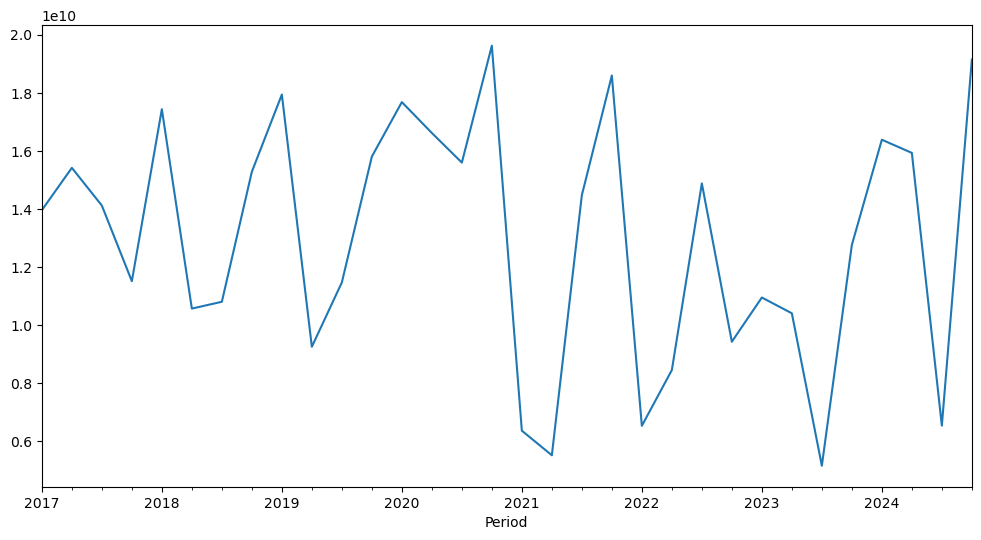

In [7]:
series.plot(figsize=(12, 6))
plt.show()

In [8]:
# Define train-validation-test split (80% train, 10% validation, 10% test)
train_index = int(len(series) * 0.8)
val_index = int(len(series) * 0.9)
train, val, test = series[:train_index], series[train_index:val_index], series[val_index:]


In [9]:
# Define train-validation-test split (80% train, 10% validation, 10% test)
train_index = int(len(series) * 0.8)
val_index = int(len(series) * 0.9)
train, val, test = series[:train_index], series[train_index:val_index], series[val_index:]


In [10]:
# Define parameter ranges for SARIMA tuning
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S = 12  # Quarterly seasonality

best_score, best_cfg = float("inf"), None

# Grid search over SARIMA parameter combinations
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(val))
        error = mean_absolute_error(val, predictions)
        if error < best_score:
            best_score, best_cfg = error, (p, d, q, P, D, Q)
    except:
        continue


c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\

In [11]:
print(f"Best SARIMA parameters: {best_cfg} with MAE of {best_score:.2f}")

Best SARIMA parameters: (5, 2, 3, 1, 0, 0) with MAE of 702795701.14


In [12]:
# Train best SARIMA model on train+validation
best_p, best_d, best_q, best_P, best_D, best_Q = best_cfg
final_model = SARIMAX(pd.concat([train, val]), order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, S),
                      enforce_stationarity=False, enforce_invertibility=False)
final_model_fit = final_model.fit(disp=False)

# Predict with the optimized SARIMA model
final_predictions = final_model_fit.forecast(steps=len(test))

# Calculate new performance metrics
final_mae = mean_absolute_error(test, final_predictions)
final_rmse = np.sqrt(mean_squared_error(test, final_predictions))

c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


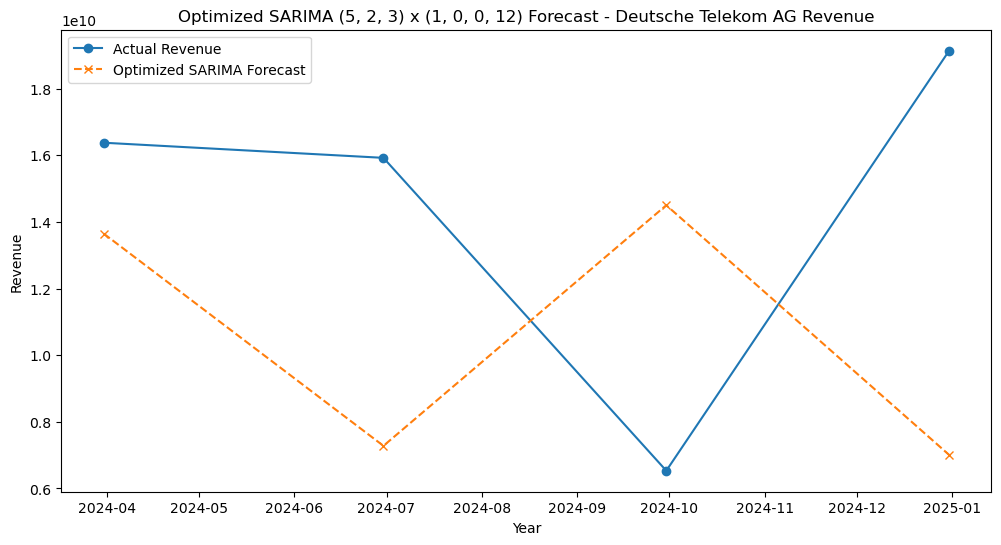

In [13]:
# Plot optimized forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Revenue", marker="o")
plt.plot(test.index, final_predictions, label="Optimized SARIMA Forecast", linestyle="dashed", marker="x")
plt.xlabel("Year")
plt.ylabel("Revenue")
plt.title(f"Optimized SARIMA ({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {S}) Forecast - {company} Revenue")
plt.legend()
plt.show()


In [14]:
# Print results
print(f"Best SARIMA Configuration: ({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {S})")
print(f"Final MAE: {final_mae}")
print(f"Final RMSE: {final_rmse}")


Best SARIMA Configuration: (5, 2, 3) x (1, 0, 0, 12)
Final MAE: 7869420567.857117
Final RMSE: 8557699075.628117
